In [1]:
import pandas as pd

In [6]:
train=pd.read_csv("C:/Users/yashc/Downloads/Analyze_This/Training_Dataset.csv")
Data_Dict=pd.read_csv("C:/Users/yashc/Downloads/Data_Dictionary.csv")
test=pd.read_csv("C:/Users/yashc/Downloads/Analyze_This/Leaderboard_Dataset.csv")
sample=pd.read_csv("C:/Users/yashc/Downloads/Analyze_This/Sample_Solution.csv")

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np

In [8]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_curve,precision_recall_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC,SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split


C:\Users\yashc\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
def makeindice(train):
    train['Indicator_ex']=0
    train.loc[train['mvar46']==1, 'Indicator_ex']='Supp'
    train.loc[train['mvar47']==1, 'Indicator_ex']='Elite'
    train.loc[train['mvar48']==1, 'Indicator_ex']='Credit'
    
    train['Indicator_ac']=0
    train.loc[(train['mvar49']+train['mvar50']+train['mvar51'])==0, 'Indicator_ac']='na'
    train.loc[train['mvar49']==1, 'Indicator_ac']='Supp'
    train.loc[train['mvar50']==1, 'Indicator_ac']='Elite'
    train.loc[train['mvar51']==1, 'Indicator_ac']='Credit'
makeindice(train)    

In [10]:
train['Acceptance_chance']=0
train.loc[train.Indicator_ac!='na',"Acceptance_chance"]=1

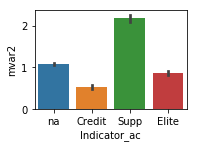

In [11]:
train.groupby('mvar2').Acceptance_chance.mean().plot(kind='bar')
plt.subplot(222)
sns.barplot(data=train,y='mvar2',x='Indicator_ac')
#mvar2 ie family size is also very important fator in determining Acceptance_chance or the card selected as it increases with 
#increases with increase in family size

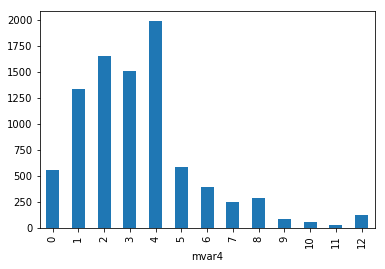

In [12]:
train.groupby('mvar4').Acceptance_chance.sum().plot(kind="bar")
#chance of accepting a card increases with number of cards they had last year but only til 4 after that it drops which is obvious
#since they already have plenty of cards

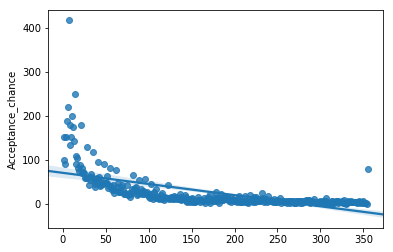

In [13]:
train.groupby("mvar5").Acceptance_chance.sum()
#train.groupby('mvar5').Acceptance_chance.sum()
sns.regplot(train.sort_values('mvar5').mvar5.unique(),train.groupby("mvar5").Acceptance_chance.sum())
#mvar 5 is the number of months the customer's account has been active ,the acceptance chance seems to decrease as the number of 
#months increases ,this means that people have stopped using their accounts

0.3070714371762438

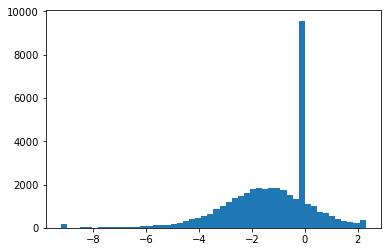

In [14]:
plt.hist((np.log(train.mvar7)),bins=50)
train[train.mvar7==.7969].Acceptance_chance.mean()

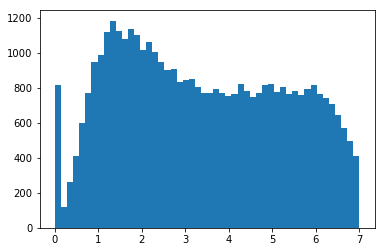

0.7969     8301
10.0000     252
0.0001      176
0.0014       24
0.0241       23
Name: mvar7, dtype: int64

In [15]:
#mvar11,internal probability score for affinity towards high bussiness expenditure
plt.hist((train.mvar11),bins=50)
plt.show()
train.mvar7.value_counts().head()

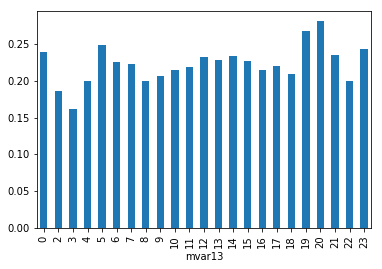

In [16]:
#mvar13 no.of times customer has made payment against the card in last 1 year
train.groupby('mvar13').Acceptance_chance.mean().plot(kind='bar')

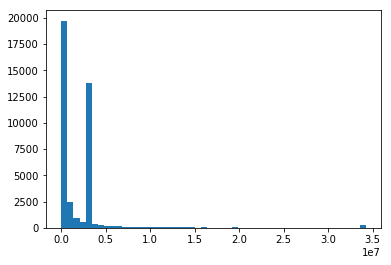

In [17]:
#mvar9
plt.hist(train.mvar9,bins=50)
plt.show()

In [18]:
train[train.mvar9<0.3*(10**7)].shape
#mvar9 ie income is not distributed properly after almost 0.3*10^7 there are very few entries ,also note that there are entries 
#where income is not known

(37155, 55)

Axes(0.125,0.125;0.775x0.755)
________________________________________________________________________________
Supp      17033
Elite     11656
Credit    11311
Name: Indicator_ex, dtype: int64


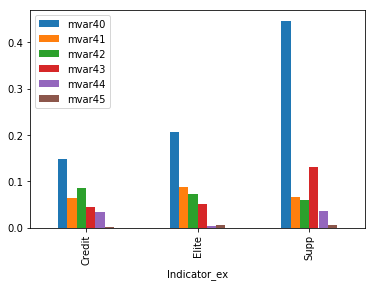

In [19]:
#IMPORTANT TABLE
print train.groupby(['Indicator_ex'])['mvar40','mvar41','mvar42','mvar43','mvar44','mvar45'].mean().plot(kind='bar')
print "__"*40
print train.Indicator_ex.value_counts()

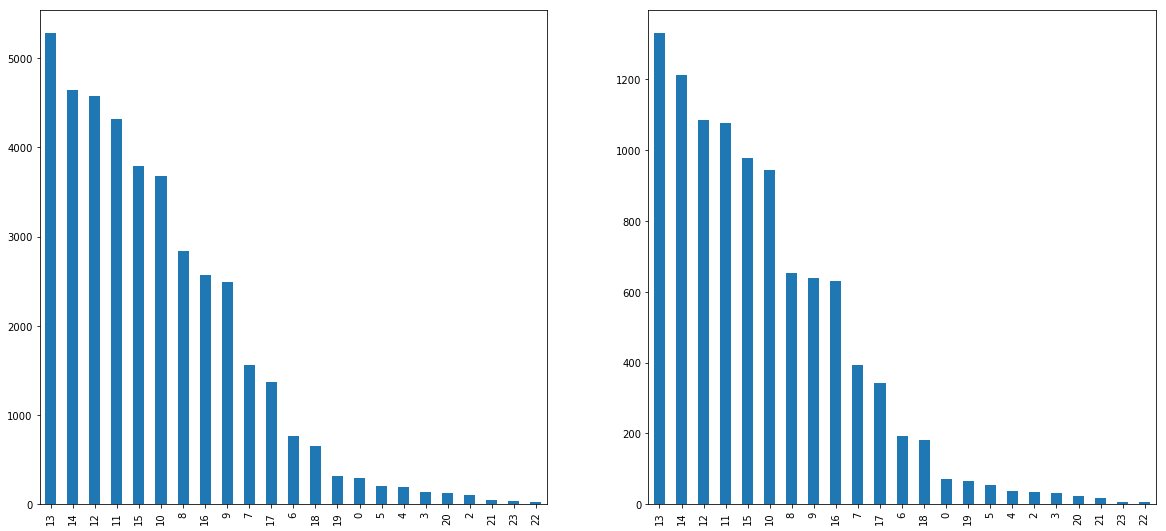

In [20]:
#number of times customers have used cards in last 1 year
fig=plt.figure(figsize=(20,20))
plt.subplot(221)
train.mvar13.value_counts().plot(kind='bar')
plt.subplot(222)
test.mvar13.value_counts().plot(kind='bar')

In [21]:
#total spending is highly correlated with other spendings ,drop all other bills,use total spending summing all quaters.
def drop_1(data):
    features=['mvar16', 'mvar17', 'mvar18', 'mvar19',
       'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24', 'mvar25',
       'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30', 'mvar31',
       'mvar32', 'mvar33', 'mvar34','mvar35']
    for i in features:
        data.drop(i,axis=1,inplace=True)

In [22]:
drop_1(train)
drop_1(test)

In [9]:
def spend_total(data):
    data['mvartotal']=data['mvar36']+data['mvar37']+data['mvar38']+data['mvar39']
    for i in ['mvar36','mvar37','mvar38','mvar39']:
        data.drop(i,axis=1,inplace=True)

In [10]:
spend_total(train)
spend_total(test)
#sum total of spending is taken

In [11]:
le1=LabelEncoder()
le2=LabelEncoder()
train['mvar12']=le1.fit_transform(train.mvar12)
test['mvar12']=le2.fit_transform(test.mvar12)

In [12]:
#calculating unknown income using known ones
def income_calculator(data):
    svr=SVR(kernel='rbf')
    svr.fit(data[data.mvar9!=0][['mvar4', 'mvar5', 'mvar6',
       'mvar7', 'mvar8',  'mvar10', 'mvar11', 'mvar12', 'mvar13',
       'mvar14', 'mvar15','mvartotal']],data[data.mvar9!=0].mvar9)
    pred_income=svr.predict(data[data.mvar9==0][['mvar4', 'mvar5', 'mvar6',
        'mvar7', 'mvar8',  'mvar10', 'mvar11', 'mvar12', 'mvar13',
       'mvar14', 'mvar15','mvartotal']])
    return pred_income
    

In [13]:
svr1=SVR(kernel='rbf')
svr1.fit(test[test.mvar9!=0][['mvar4', 'mvar5', 'mvar6',
       'mvar7', 'mvar8',  'mvar10', 'mvar11', 'mvar12', 'mvar13',
       'mvar14', 'mvar15','mvartotal']],test[test.mvar9!=0].mvar9)
pred_income2=svr1.predict(test[test.mvar9==0][['mvar4', 'mvar5', 'mvar6',
        'mvar7', 'mvar8',  'mvar10', 'mvar11', 'mvar12', 'mvar13',
       'mvar14', 'mvar15','mvartotal']])
   

In [14]:
train.loc[train.mvar9==0,'mvar9']=income_calculator(train)
test.loc[test.mvar9==0,'mvar9']=pred_income2

In [15]:
#converting the income series in bins for both test and train data ,moreover the bins taken in both cases are identical
train['mvar9']=pd.qcut(train.mvar9,10,duplicates='drop')
test['mvar9']=pd.cut(test.mvar9,bins=(59.999, 78215.8, 120938.2, 204929.6, 412517.0,872085.0, 2918974.0, 34207020.0))
le4=LabelEncoder()
train['mvar9']=le4.fit_transform(train.mvar9)
test['mvar9']=le4.fit_transform(test.mvar9)

In [16]:
X=train.drop(['Indicator_ex','mvar1','mvar3'],axis=1)

In [17]:
def log(data):
    log_transformations=['mvartotal','mvar7','mvar11']
    for i in log_transformations:
        data[i]=np.log(data[i]+1)
log(test)
log(X)   

In [18]:
X['mvartotal']=pd.qcut(X.mvartotal,5)
test['mvartotal']=pd.cut(test.mvartotal,bins=(-0.001, 9.843, 10.641, 11.248, 11.844, 12.621, 18.794))

In [19]:
le5=LabelEncoder()
X['mvartotal']=le5.fit_transform(X.mvartotal)
test['mvartotal']=le5.fit_transform(test.mvartotal)

In [20]:
index=X[X.Acceptance_chance==0].index
X=X.drop(index[0:15000])


In [21]:
X_acceptance=X.drop(['cm_key',"Acceptance_chance","Indicator_ac","mvar40","mvar41","mvar42",'mvar46', 'mvar47', 'mvar48','mvar49', 'mvar50', 'mvar51'],axis=1)


In [22]:
test.drop(['mvar1','mvar3'],axis=1,inplace=True)

In [23]:
X_train,X_test,y_train,y_test=train_test_split(X_acceptance,X["Acceptance_chance"],test_size=0.2)

In [24]:
rf=RandomForestClassifier(n_estimators=1000)
rf.fit(X_acceptance,X["Acceptance_chance"])



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [25]:
prediction_test_rf=rf.predict(test.drop(['cm_key','mvar40','mvar41','mvar42'],axis=1))
proba=rf.predict_proba(test.drop(['cm_key',"mvar40","mvar41","mvar42"],axis=1))


In [26]:
test['proba']=np.amax(proba,axis=1)
test["Acceptance_chance"]=prediction_test_rf


In [27]:
test=test.sort_values('proba',ascending=False)

In [28]:
sub=test[test.Acceptance_chance==1]

In [29]:
sub=sub.iloc[0:1000,:]

In [30]:
X["Indicator_ac"]=X.Indicator_ac.map({'na':0,'Supp':1,"Elite":2,"Credit":3})

In [31]:
card_train=X[X.Indicator_ac!=0]

In [32]:
lr=LogisticRegression()

In [33]:
lr.fit(card_train[['mvar2', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8',
       'mvar9', 'mvar10', 'mvar11', 'mvar12', 'mvar13', 'mvar14', 'mvar15',
        'mvar43', 'mvar44', 'mvar45','mvartotal']],card_train["Indicator_ac"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
sub["card"]=lr.predict(sub[['mvar2', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8',
       'mvar9', 'mvar10', 'mvar11', 'mvar12', 'mvar13', 'mvar14', 'mvar15',
        'mvar43', 'mvar44', 'mvar45','mvartotal']])

In [35]:
sub['proba']=lr.predict_proba(sub[['mvar2', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8',
       'mvar9', 'mvar10', 'mvar11', 'mvar12', 'mvar13', 'mvar14', 'mvar15',
        'mvar43', 'mvar44', 'mvar45','mvartotal']])

In [36]:
#sub=sub.sort_values('proba')

In [37]:
sub["card"]=sub['card'].map({1:"Supp",2:"Elite",3:"Credit"})

In [38]:
answer=sub[["cm_key",'card']]
answer.set_index("cm_key",inplace=True)

In [39]:
filepath='C:/Users/yashc/Desktop/knob_IIT_Roorkee.csv'
answer.to_csv('C:/Users/yashc/Desktop/knob_IIT_Roorkee.csv',header=False)